In [ ]:
#@title Pip installs
!pip install nevopy
!pip install mistree

In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [ ]:
#@title Imports and Notebook Utilities
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import nevopy as ne
import matplotlib.pylab as pl
import time
import matplotlib.cm as cm
import matplotlib as mpl
import sys
import glob
import matplotlib.pyplot as plt
import numpy.ma as ma
import mistree as mist
from matplotlib import colors
import math

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename=None, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

In [ ]:
#@title Image Utils

def to_alpha(x):
  return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb

In [ ]:
# ----- Neighborhood/Channel Parameters ----- 
moore_f = (np.array([ 1,  1,  1,  0,  0,  -1, -1, -1]),
           np.array([-1,  0,  1, -1,  1,  -1,  0,  1])) # Moore neigh indices

von_n = (np.array([-1,  0,  0, 1]),
         np.array([ 0, -1,  1,  0])) # Von Neumann neighborhood indices

moore_f = (np.array([ 1,  1,  1,  0,  0,  0,  -1, -1, -1]),
           np.array([-1,  0,  1, -1,  0,  1,  -1,  0,  1])) # Includes center

von_n_f = (np.array([-1,  0,  0,  0, 1]),
           np.array([ 0, -1,  0,  1,  0])) # Includes center

KERNEL = von_n
KERNEL_F = von_n_f
N_NEIGHS = len(KERNEL[0])
N_HIDDEN = 4
N_CHANNELS = 3 + N_HIDDEN # Number of channels per cell

LIFE = 0 # Index into channel
FOOD = 1 # Index into channel
RESV = 2
HIDDEN = 3 # Index of first hidden channel

# ----- Environment -----
ESIZE = 32 # width/height of the environment
ENV_SHAPE=(N_CHANNELS,ESIZE,ESIZE)
CUT_SHAPE = (ESIZE-2, ESIZE-2)
INDS = np.arange(0,CUT_SHAPE[0]*CUT_SHAPE[1])

# Lévy dust parameters (for distributing food)
ALPHA = 1. # 1.2 # Slope of the power law, to play with
T_0 =  0.6 # 0.3 # Minimum step size of flight, to play with
FOOD_AMOUNT = 16 # Number of points created, they stack on each other
MAX_FOOD = 4

# ----- NN Attributes -----
# TODO: explore larger perceptive fields? sobel filters?
INPUT_SHAPE = (1 + N_NEIGHS) * N_CHANNELS # Center + neighs, all channels
OUTPUT_SHAPE = N_NEIGHS + N_HIDDEN # Center Life, resv from neighs, hidden channels for center

# ----- Physical Constraints -----
LIFE_COST = 0.3 # How much life is depleted per time step
MIN_LIFE = 0.1 # Life below this is treated as dead
LIFE_TRANSFER_RATE = 0.2 # Amount of food transferrable by 1 unit of life
FOOD_TRANSFER_RATE =  1 # Amount of life transferrable by 1 unit of food

In [ ]:
#@title Utils to display environment

# TODO: Show the color bar to get a sense of scale
def ch_image(env, channel, cmap=None):
  if cmap is None:
    if channel == FOOD:
      cmap = cm.copper
    elif channel == LIFE:
      cmap = cm.gray
    else:
      cmap = cm.hot

  norm = mpl.colors.Normalize(env[channel].min(),env[channel].max())
  m = cm.ScalarMappable(norm = norm, cmap = cmap)
  return m.to_rgba(env[channel])

def ch_plot(env, channel, cmap=None):
  if cmap is None:
    if channel == FOOD:
      cmap = cm.copper
    elif channel == LIFE:
      cmap = cm.gray
    else:
      cmap = cm.hot

  plt.imshow(env[channel], cmap=cmap, interpolation='nearest')
  plt.colorbar()
  plt.show()

def ch_plimage(env,channel,cmap=cm.hot):
  if cmap is None:
    if channel == FOOD:
      cmap = cm.copper
    elif channel == LIFE:
      cmap = cm.gray
    else:
      cmap = cm.hot

  plt.clf()
  fig = plt.gcf();
  plt.imshow(env[channel], cmap=cmap, interpolation='nearest')
  plt.colorbar()
  fig = plt.gcf()
  fig.canvas.draw()
  # Now we can save it to a numpy array.
  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  # buf = io.BytesIO()
  # plt.savefig(buf)
  # buf.seek(0)
  return data
def gen_vid(frames, fname="test.mp4"):
  with VideoWriter(fname) as vid:
      for i, f in enumerate(frames):
        vid.add(to_rgb(zoom(np.array(f),256/ESIZE)))
  return fname

In [ ]:
#@title General Utilities
def rprint(text):
  sys.stdout.write("\r"+text)
  sys.stdout.flush()

In [ ]:
#@title Slime Mold Environmental Constraints

'''
Applies environmental/physical/logical constraints on the output of the agent
Params:
  - chunk: the initial N_CHANNELSx3x3 grid containing the central cell being updated
  - desire: the agent's desired set of channels for the central cell
Constraints/Rules:
  - There must be life in the neighborhood for life desire to be granted
  # DEFUNCT - An increase in food must be evenly drained from neighboring cells
  # DEFUNCT - A decrease in food is spread evenly to neighboring cells
  - Only life(cell)*transfer_cost amount of food can be drained from a cell 
  - Food is consumed proportional to the amount of life
  - Life is lost proportional to the amount of food it doesn't get
  - Hidden channels [FOOD+1:,...] can remain without life (electrochemical goo?)
  - Hidden channels can only be changed with life present
  - The central cell can only receive a life's amount of food
  - Life can only change by MAX_GROWTH at a time
'''

def _apply_food_life_penalties(center, delta_life):
  # fitness = 0
  # Consume necessary food
  center[FOOD] -= center[LIFE] * LIFE_COST + GROWTH_COST * min(delta_life,0)
  # If there was not enough, punish the cell and lower its life
  if center[FOOD] < 0:
    # fitness = center[FOOD]
    center[LIFE] += center[FOOD] * center[LIFE] * DEATH_RATE # Food is negative..
    center[FOOD] = 0 # We don't want negative food
    
    if center[LIFE] < MIN_LIFE:
      center[LIFE] = 0

  # return fitness

# Returns the total amount of food transferred in or out, for fitness calcs
# Food desire is length of neighborhood, sum(desire) is increase in central food
def _transfer_food(center, neighs, food_desire):
  food_desire *= min(sum(food_desire), center[LIFE] * FOOD_CAPACITY)/sum(food_desire)
  avail_food = np.minimum(neighs[LIFE] * TRANSFER_RATE, neighs[FOOD])
  food_desire = np.minimum(np.absolute(food_desire), avail_food)
  neighs[FOOD] -= food_desire
  center[FOOD] += sum(food_desire)  

  # avail_food = neighs.sum()
  # distr = neighs / avail_food
  # if food_desire < 0:
  #   delta_food = 0
  #   # Uncomment if you central cell should act as a "pump," sending food to neighs
  #   # delta_food = min(abs(food_desire), min(center[FOOD], center[LIFE]))
  # else:
  #   delta_food = min(food_desire, avail_food)

  # neighs[FOOD] -= distr * delta_food
  # center[FOOD] += delta_food
  # # TODO: visualize delta_food? to see sources and sinks
  # return abs(delta_food)

# Returns the total amount of food transferred in or out, for fitness calcs
def apply_constraints(center, neighs, desires):
  '''
  TODO:
    - Consider negative food desire
    - Ensure transport feasibility:
      - Center can only get a life's amount of food too
  '''
  # If life is around, at least update central life and hidden channels
  if neighs[LIFE].sum() > 0:
    _transfer_food(center, neighs, desires[FOOD:FOOD+len(KERNEL[0])])

    # To ensure even transfer *from* center, this is done after transfer
    sign = desires[LIFE]/desires[LIFE]
    desires[LIFE] = sign * max(MAX_GROWTH, abs(desires[LIFE]))
    center[LIFE] += desires[LIFE]
    center[FOOD+len(KERNEL[0]):] = desires[FOOD+len(KERNEL[0]):] # Food desire is len(neighbors) starting at FOOD
    _apply_food_life_penalties(center, desires[LIFE])

    if center[LIFE] <= MIN_LIFE: 
      center[LIFE] = 0.
  else:
    center[LIFE] = 0.
  # return delta_food # TODO: Consider cost function - does it 

In [ ]:
class constraints:
  def __init__(self):
    self.life_cost=LIFE_COST
    self.min_life = MIN_LIFE
    self.life_transfer_rate=LIFE_TRANSFER_RATE
    self.food_transfer_rate=FOOD_TRANSFER_RATE
    self.max_life=1.

default_constraints = constraints()

In [ ]:
#@title Old physics
'''
  - Life increases from food first (anywhere in neigh?)
  - Increase ^ is proportional to food val
  - Life drains from neigh life otherwise
  - Life decreases by DEATH_RATE every time step 
  - Only TRANSFER_RATE life can be drained from any one neighbor
  - 
'''
# def apply_physics(center, neighs, desires, constraints=default_constraints):
#   con=constraints
#   if neighs[LIFE].sum() > 0 or center[LIFE] > 0:
#     center[HIDDEN:] = desires[N_NEIGHS:]
#     center[LIFE] += con.food_transfer_rate * center[FOOD] # Life appears on nearby food
#     center[LIFE] = min(center[LIFE],con.max_life)

#     if center[LIFE] > con.min_life or sum(desires[:N_NEIGHS]) > 0.1:
#       # Neighbor's life will change by at most what they can transfer
#       delta_neigh = np.minimum(con.life_transfer_rate * neighs[LIFE],desires[:N_NEIGHS])
#       delta_center = sum(delta_neigh)
#       # A cell can only hold 1 unit of life
#       adj = min(delta_center, (con.max_life-center[LIFE]))/delta_center
#       neighs[LIFE] -= delta_neigh * adj
#       center[LIFE] += delta_center * adj

#     center[LIFE] -= center[LIFE] * con.life_cost
#     center[LIFE] = min(center[LIFE],con.max_life)
#     if center[LIFE] <= con.min_life:
#       center[LIFE] = 0

In [ ]:
#@title Slime mold env tests
# Test create new cell that is less than sum
# channel 1 is food, channel 2 is life
env1 = np.zeros((N_CHANNELS,ESIZE,ESIZE))
env1[FOOD, 5:8,3:6] =  np.array([[0,0,0],
                                  [0,0,0],
                                  [0,0,0]])

env1[LIFE,5:8,3:6] = np.array([[0,0,0],
                                [0,0,0],
                                [0,1,0]])
desire = np.arange(N_NEIGHS + N_HIDDEN)
desire[1:1+N_NEIGHS] = [1,1,1,1]
desire[LIFE] = 1

# for i in range(3):
#   apply_constraints(env1[:,6,4], env1[:,KERNEL[0] + 6, KERNEL[1] + 4], desire)
ch_plot(env1[:,4:9,2:7],LIFE)
print("AFTER")
apply_physics(env1[:,6,4], env1[:,KERNEL[0] + 6, KERNEL[1] + 4], desire)
ch_plot(env1[:,4:9,2:7],LIFE)

ImportError: ignored

<Figure size 432x288 with 2 Axes>

AFTER


ImportError: ignored

<Figure size 432x288 with 2 Axes>

In [ ]:
care=env1[:,4:9,2:7]
care[0,KERNEL[0] + 3, KERNEL[0] + 2]
# care[0]
KERNEL

(array([-1,  0,  0,  1]), array([ 0, -1,  1,  0]))

In [ ]:
#@title Generates a levy dust distribution of food

def get_dust(points=FOOD_AMOUNT, t_0=T_0, alpha=ALPHA, size=ESIZE):
  x, y = mist.get_levy_flight(points, t_0=t_0, alpha=alpha, mode='2D', box_size=size)
  return np.array([x,y]).T

# Turns continuous dust into grid of food densities
def bin_dust(dust, size=ESIZE):
  food_grid = np.zeros((size,size))
  dust = np.array(dust, dtype=np.int64)
  dust, density = np.unique(dust, axis=0, return_counts=True)
  food_grid[dust[:,0],dust[:,1]] = density
  return food_grid

def get_bin_dust(points=FOOD_AMOUNT, t_0=T_0, alpha=ALPHA, size=ESIZE):
  dust = get_dust(points, t_0, alpha, size)
  return bin_dust(dust,size)

def gen_padded_env(food_permanence=FOOD_PERMANENCE, points=FOOD_AMOUNT, t_0=T_0, alpha=ALPHA, size=ESIZE-2):
  env=np.zeros((N_CHANNELS,ESIZE,ESIZE)) # TODO: Randomize initial grid?
  food = get_bin_dust(points, t_0, alpha, size) * food_permanence
  env[FOOD,1:ESIZE-1,1:ESIZE-1] = food # pad with 1 cell of nothing
  return env

# Innoculate the cell with the most food - this is likely to be surrounded 
# by more food given def of levy dust
def innoculate_env(env):
  maxfood = np.unravel_index(np.argmax(env[FOOD]), env[FOOD].shape)
  env[LIFE][maxfood[0],maxfood[1]] = 1
  return env

In [ ]:
#@title Tester Agents
class RandomAgent:
    def reset(self):
        pass

    def process(self, x):
        # y = np.random.randint(2)
        return np.random.rand(OUTPUT_SHAPE)

class LameAgent:
    def __init__(self,mult):
      self.mult=mult

    def reset(self):
        pass
    def process(self, x):
        # y = np.random.randint(2)
        y=np.zeros(OUTPUT_SHAPE)
        y[:N_NEIGHS] += [self.mult,self.mult,self.mult,self.mult]
        return y 

In [ ]:
#@title Apply agent to environmet

def add_frame(frames, env):
  fframe = ch_image(env,FOOD, cmap=cm.copper)
  lframe = ch_image(env,LIFE, cmap=cm.gray)
  frame = np.append(fframe,lframe, axis=0)
  if frames is None:
    frames = np.array([frame])
  else:
    frames = np.append(frames, [frame], axis=0)
  return frames

def add_frames(frames, new_frames):
  if new_frames is not None and len(new_frames) > 0:
    if frames is None:
      frames = new_frames
    else:
      frames = np.append(frames, new_frames,axis=0)
  return frames

# Stochastically applies agent to every alive cell
def apply_agent(agent, env, gen_frames=False, vid_speed=10, constraints=default_constraints):
  np.random.shuffle(INDS)
  coords = np.unravel_index(INDS, CUT_SHAPE)
  frames = None

  total_steps = 0
  # start one index in, the list is 2 short so it will stop with one to go
  for i,j in zip(coords[0]+1,coords[1]+1): 
    input = env[:,KERNEL_F[0]+i,KERNEL_F[1]+j]
    if input[LIFE].sum() > 0:
      desires = agent.process(input.flatten())
      apply_physics(env[:,i,j],env[:,KERNEL[0]+i,KERNEL[1]+j], desires, constraints=constraints)

      if gen_frames and vid_speed < 10 and total_steps%(math.pow(2,vid_speed)) == 0:
        frames = add_frame(frames,env)
    
      total_steps += 1

  if gen_frames:
    frames = add_frame(frames, env)

  return frames

# Vid speed of 10 generates a frame for every full application of an agent
def apply_agent_n(agent, env, n=10, apply_until_dead=False, gen_frames=False, vid_speed=10, constraints=constraints):
  frames=None
  i=0
  fitness = 0
  running=True
  # tot_delta=0
  while running:
    temp_frames = apply_agent(agent, env, gen_frames, vid_speed, constraints=constraints)
    if gen_frames:
      frames = add_frames(frames,temp_frames)

    if apply_until_dead:
      running = env[LIFE].sum() > 0 
    else:
      running = i<n
    i+=1
  return frames

NameError: ignored

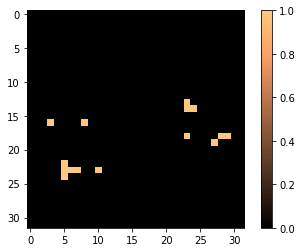

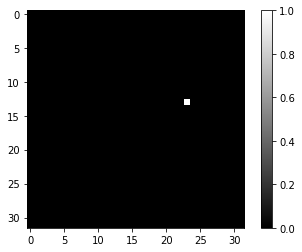

In [ ]:
test_env = gen_padded_env(food_permanence=1, points=15, t_0=1, alpha=1.)
test_env = innoculate_env(test_env)
ch_plot(test_env,FOOD)
ch_plot(test_env,LIFE)
# imshow(zoom(ch_image(test_env,FOOD),16))
# imshow(zoom(ch_image(test_env,LIFE, cmap = cm.cool),16))
agent=RandomAgent()
# np.unravel_index(np.argmax(test_env[LIFE]),test_env.shape)

In [ ]:
my_cons = constraints()
my_cons.min_life = 0.1
my_cons.food_transfer_rate = 0.5
my_cons.life_cost = 0.35
my_cons.life_transfer_rate = .3
my_cons.max_life = 10.0

frames = apply_agent_n(RandomAgent(), np.copy(test_env), n=50, gen_frames=True, vid_speed=8, constraints=my_cons)
mvp.ipython_display(gen_vid(frames))

In [ ]:
 !python -V

Python 3.7.15


In [ ]:
POP_SIZE=10

In [ ]:
counter=0
ENV=test_env
def fitness_function(genome, env=None, log=False, vid_speed=10):
  my_cons = constraints()
  my_cons.min_life = 0.1
  my_cons.food_transfer_rate = 0.25
  my_cons.life_cost = 0.3
  my_cons.life_transfer_rate = .25
  my_cons.max_life = 1.0

  # if ENV is None or counter%POP_SIZE==0:
  #   ENV = gen_padded_env()
  #   ENV = innoculate_env(env)
  # env=np.copy(ENV)
  env=np.copy(ENV)
  
  # frames = apply_agent_n(agent, env, max_applications, gen_frames=log)
  frames = apply_agent_n(genome, env, n=30, gen_frames=log, vid_speed=vid_speed, constraints=my_cons)
  if log:
    return env[LIFE].sum(), gen_vid(frames)
  else:
    return env[LIFE].sum()

In [ ]:
fitness,vid=fitness_function(LameAgent(0.1),log=True,vid_speed=8)
print(fitness)
mvp.ipython_display(vid)

52.78822231976112


In [ ]:
population = ne.neat.NeatPopulation(
    size=POP_SIZE,                 # number of genomes in the population
    num_inputs=INPUT_SHAPE,  # number of input nodes in the genomes
    num_outputs=OUTPUT_SHAPE,   # number of output nodes in the genomes
)

In [ ]:
history = population.evolve(generations=10,
                            fitness_function=fitness_function)

>> GENERATION 3 SUMMARY:
. Mass extinction counter: 3 / 15
. Processing time:  31.9178s

|---------------|--------------|--------------|--------------|--------------|
|     NAME      |   CURRENT    |     PAST     |   INCREASE   | INCREASE (%) |
|===========================================================================|
| Best fitness  |     NAN      |     NAN      |     +NAN     |    +nan%     |
|---------------|--------------|--------------|--------------|--------------|
|Avg population |     NAN      |     NAN      |     +NAN     |    +nan%     |
|    fitness    |              |              |              |              |
|---------------|--------------|--------------|--------------|--------------|
|    Weight     |    74.00%    |    72.67%    |    +1.33%    |      -       |
|mutation chance|              |              |              |              |
|---------------|--------------|--------------|--------------|--------------|
|    Weight     |    16.00%    |    14.00%    |    +2

KeyboardInterrupt: ignored

In [ ]:
test_env = gen_padded_env()
test_env = innoculate_env(test_env)
ch_plot(test_env,FOOD)
ch_plot(test_env,LIFE)

In [ ]:
best_genome = population.fittest()
fitness, vid = fitness_function(best_genome, env=np.copy(test_env), log=True, vid_speed=8)
print()
print(fitness)
mvp.ipython_display(vid)


nan


In [ ]:
fitness, vid = fitness_function(LameAgent(), env=np.copy(test_env), log=True)
print()
print(fitness)
mvp.ipython_display(vid)

NameError: ignored

In [ ]:
fitness, vid = fitness_function(RandomAgent(), env=np.copy(test_env), log=True, vid_speed=5)
print()
print(fitness)
mvp.ipython_display(vid)

NameError: ignored

In [ ]:
fitness, vid = fitness_function(NoAgent(), log=True)
print()
print(fitness)
mvp.ipython_display(vid)

Adding 1 Frames
6.0


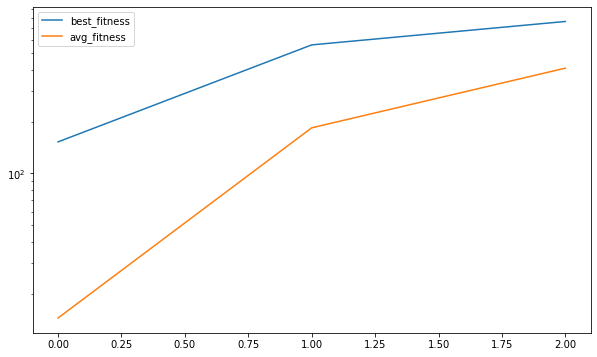

In [ ]:
history.visualize()

In [ ]:
best_genome.visualize()

NameError: ignored

# Growing Neural Cellular Automata example code:

In [ ]:
seed = np.random.rand(1, ESIZE, ESIZE, N_CHANNELS).astype(np.float32)
seed[:, ESIZE//2, ESIZE//2, 3:] = 1.0

In [ ]:
from tensorflow.keras.layers import Conv2D

class CA(tf.Module):
  def __init__(self):
    self.model = tf.keras.Sequential([
        Conv2D(64, 3, padding='same', activation=tf.nn.relu),
        Conv2D(N_CHANNELS, 1)
    ])

  @tf.function
  def __call__(self, x):
    return x + self.model(x)

In [ ]:
out_fn = time.strftime("%Y%m%d-%H%M%S-FOOD") + ".mp4"
ca = CA()

x = seed

In [ ]:
cframes=[]
with VideoWriter(out_fn) as vid:
  for i in range(64):
    cframes.append(x[0])
    vid.add(zoom(to_rgb(x[0])))
    x = ca(x)
print(out_fn)
mvp.ipython_display(out_fn)

20221021-070853-FOOD.mp4


In [ ]:
x[0]

<tf.Tensor: shape=(32, 32, 8), dtype=float32, numpy=
array([[[ 3.28444650e+06, -1.92491020e+07, -3.23877875e+06, ...,
          8.02827150e+06,  2.98452438e+05, -1.33851720e+07],
        [-1.14625900e+07, -2.52877720e+07, -5.02843100e+06, ...,
          4.94847000e+06, -3.08919040e+07,  2.83203560e+07],
        [ 3.01693720e+07, -1.37821312e+06, -4.56339360e+07, ...,
          5.48250560e+07, -8.99303360e+07, -8.57330900e+06],
        ...,
        [-1.32860576e+08, -7.21146320e+07,  2.12391920e+07, ...,
         -1.04941120e+08, -9.95460160e+07,  9.49185520e+07],
        [-5.41034040e+07,  3.25021280e+07,  1.90070800e+07, ...,
          1.59303970e+07, -2.36645040e+07, -8.79735360e+07],
        [-1.94576140e+07,  1.97601350e+06,  3.66813760e+07, ...,
         -3.34436880e+07,  5.84578400e+07, -3.14146020e+07]],

       [[ 2.08701620e+07, -1.40405700e+07, -1.86281220e+07, ...,
          7.92039150e+06, -1.24308300e+07, -3.25009520e+07],
        [ 6.78128900e+06,  6.25798700e+06, -1.7713

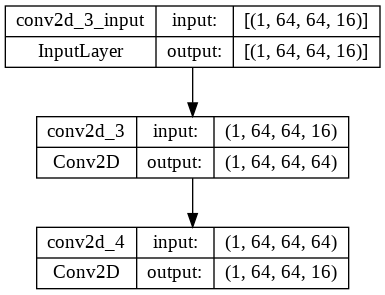

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(ca.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
hist = np.random.randint(0,100,(8,8,8))/100.0
print({index:x for index, x in np.ndenumerate(hist) if x})
for index, x in np.ndenumerate(hist):
  print(np.arra*index, x)

In [ ]:
import plotly.graph_objects as go
import numpy as np



# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for step in np.arange(0, 5, 0.1):
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#00CED1", width=6),
            name="𝜈 = " + str(step),
            x=np.arange(0, 10, 0.01),
            y=np.sin(step * np.arange(0, 10, 0.01))))

# Make 10th trace visible
fig.data[10].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to step: " + str(i)}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Frequency: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()